In [16]:
import json
import numpy as np

Step 1 Prepare dataset, we use a query and 10 docs retrieved by BM25 model as example. 

In [17]:
# load a pre-saved example file, including one query, top-10 hits by BM25, raw text documents.
with open('datasets/dbpedia-entity/bm25_example.json', 'r')as f:
    bm25_example = json.load(f)

Step 2.1 Load a pretrained ranking model from Beir. 

In [18]:
# Load a reranking model
from beir.reranking.models import CrossEncoder
model = 'cross-encoder/ms-marco-electra-base'
reranker = CrossEncoder(model)

Step 2.2, Prepare the input for reranking, be sure the ranking model has .predict(), take (query, doc) tuples as input.

In [19]:
# build query-doc pair for reranking model as input.
query = bm25_example['query']
sentence_pairs = []
for doc_id, _ in bm25_example['hits']:
    doc_text = (bm25_example['docs'][doc_id].get("title", "") + " " + bm25_example['docs'][doc_id].get("text", "")).strip()
    sentence_pairs.append([query, doc_text])
rerank_scores = reranker.predict(sentence_pairs, batch_size=10)
print(rerank_scores)

Step 3.1, Choose a doc to explain, make sure to recover the raw text of the doc.

In [21]:
# pick a document to explain, e.g., top-1 document.
r = 0  # explain the top-ranked document.
doc_ids = np.array([doc[0] for doc in bm25_example['hits']])
docids_reranked = doc_ids[np.argsort(rerank_scores)[::-1]]  # descending order.
doc_id = docids_reranked[r]
doc_exp = (bm25_example['docs'][doc_id].get("title", "") + " " + bm25_example['docs'][doc_id].get("text", "")).strip()
print(doc_exp)

Cuisine A cuisine (/kwɪˈziːn/ kwi-ZEEN; from French [kɥizin], in turn from Latin coquere = "to cook") is a style of cooking characterized by distinctive ingredients, techniques and dishes, and usually associated with a specific culture or geographic region. A cuisine is primarily influenced by the ingredients that are available locally or through trade. Religious food laws, such as Hindu, Islamic and Jewish dietary laws, can also exercise a strong influence on cuisine.


Step 3.2, Init EXS, with the ranking model, and a surrogate model to approximate the local prediction.

In [37]:
# Initiliaze EXS...
from exs import ExplainableSearch
EXS = ExplainableSearch(reranker, 'svm',)

Step 3.3, Build the necessary input to EXS, and explain!

In [38]:
# build input for explaining function, use one query as example. 
exp_input = {}
exp_input[query] = dict([(a, b) for a, b in zip(doc_ids, rerank_scores)])
print(exp_input)
# explain the picked doc, use the 1-th ranked doc as the baseline, use topk-bin method.
# the returned results include {query: (words, weights)}.
results = EXS.explain(exp_input, {query: doc_exp}, 1, 'topk-bin')

{'Szechwan dish food cuisine': {'<dbpedia:Ghanaian_cuisine>': 2.0086873e-05, '<dbpedia:Seafood_dishes>': 2.4303485e-05, '<dbpedia:Dish_(food)>': 6.642292e-05, '<dbpedia:American_Chinese_cuisine>': 5.3182488e-05, '<dbpedia:List_of_Indian_dishes>': 8.036296e-05, '<dbpedia:Traditional_food>': 2.3035003e-05, '<dbpedia:Malaysian_Indian_cuisine>': 3.416922e-05, '<dbpedia:Cuisine_of_Odisha>': 0.0016131043, '<dbpedia:Cuisine>': 0.0017985582, '<dbpedia:Gabonese_cuisine>': 4.3237404e-05}}


In [25]:
import matplotlib.pyplot as plt

def visualize(vocabs:np.array, coef: np.array, show_top: int=10):
        if len(coef.shape) > 1:  # binary, 
            coef = np.squeeze(coef)
        sorted_coef = np.sort(coef)
        sorted_idx = np.argsort(coef)
        pos_y = sorted_coef[-show_top:]
        neg_y = sorted_coef[:show_top]
        pos_idx = sorted_idx[-show_top:]
        neg_idx = sorted_idx[:show_top]

        words = np.append(vocabs[pos_idx], vocabs[neg_idx])
        y = np.append(pos_y, neg_y)
        fig, ax = plt.subplots(figsize=(8, 10))
        colors = ['green' if val >0 else 'red' for val in y]
        pos = np.arange(len(y)) + .5
        ax.barh(pos, y, align='center', color=colors)
        ax.set_yticks(np.arange(len(y)))
        ax.set_yticklabels(words, fontsize=18)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_xticks([])
        #fig.savefig('exs.pdf')
        fig.show()


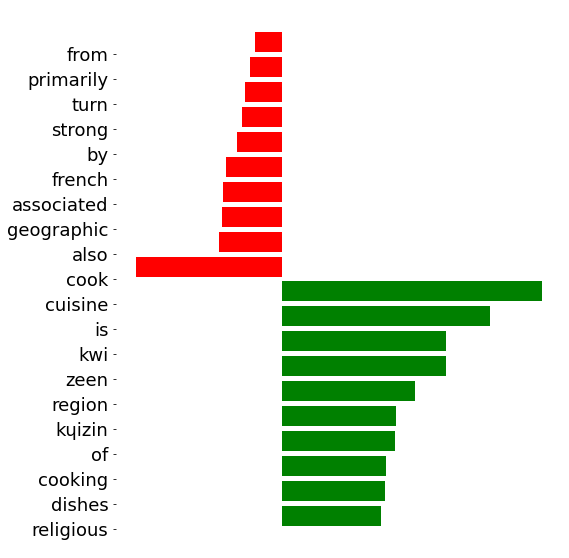

In [40]:
visualize(results[query][0], results[query][1])

In [29]:
# try logistic regression
EXS._set_exs_model('lr')
# why is 0-th doc higher than 1-th doc?
results_lr = EXS.explain(exp_input, {query: doc_exp}, 1, 'topk-bin')

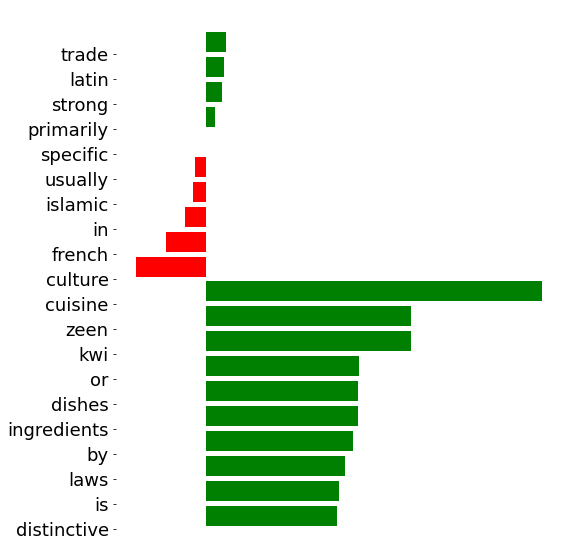

In [33]:
visualize(results_lr[query][0], results_lr[query][1])